In [1]:
import time

import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import os
import math
import pickle
import numpy as np
import skimage as ski
import skimage.io
import matplotlib.pyplot as plt

# Util methods

In [10]:
def init_dir(d):
    if not os.path.exists(d):
        os.makedirs(d)
        
def save_image(img, path, mean, std):
    img = img.copy()
    img *= std
    img += mean
    img = img.astype(np.uint8)
    ski.io.imsave(path, img)

def show_image(img, mean, std):
    img = img.copy()
    img *= std
    img += mean
    img = img.astype(np.uint8)
    ski.io.imshow(img)
    ski.io.show()

def shuffle_data(data_x, data_y):
    indices = np.arange(data_x.shape[0])
    np.random.shuffle(indices)
    shuffled_data_x = np.ascontiguousarray(data_x[indices])
    shuffled_data_y = np.ascontiguousarray(data_y[indices])
    return shuffled_data_x, shuffled_data_y

def unpickle_py2(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

def unpickle_py3(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

def unpickle(file):
    import sys
    if sys.version_info > (3, 0):
        return unpickle_py3(file)
    else:
        return unpickle_py2(file)

# Params

In [11]:
DATA_DIR = '/home/mratkovic/deeplearning/datasets/cifar-10-batches-py/'
SAVE_DIR = '/home/mratkovic/deeplearning/outputs/cifar10/'

DATA_DIR = '/home/marko/Projects/faks/DU/datasets/cifar-10-batches-py/'
SAVE_DIR = '/home/marko/Projects/faks/DU/outputs/cifar10/'
init_dir(SAVE_DIR)

config = {}
config['max_epochs'] = 40
config['batch_size'] = 50
config['save_dir'] = SAVE_DIR
config['weight_decay'] = 1e-4
lr_initial = 0.01
config['lr_policy'] = {e:{'lr':(0.9**e)*lr_initial} for e in range(1, config['max_epochs']+1)}

# Dataset

In [12]:
img_height, img_width, num_channels = 32, 32, 3
train_x = np.ndarray((0, img_height * img_width * num_channels), dtype=np.float32)
train_y = []
for i in range(1, 6):
  subset = unpickle(os.path.join(DATA_DIR, 'data_batch_%d' % i))
  train_x = np.vstack((train_x, subset['data']))
  train_y += subset['labels']
train_x = train_x.reshape((-1, num_channels, img_height, img_width)).transpose(0,2,3,1)
train_y = np.array(train_y, dtype=np.int32)

subset = unpickle(os.path.join(DATA_DIR, 'test_batch'))
test_x = subset['data'].reshape((-1, num_channels, img_height, img_width)).transpose(0,2,3,1).astype(np.float32)
test_y = np.array(subset['labels'], dtype=np.int32)

valid_size = 5000
train_x, train_y = shuffle_data(train_x, train_y)
valid_x = train_x[:valid_size, ...]
valid_y = train_y[:valid_size, ...]
train_x = train_x[valid_size:, ...]
train_y = train_y[valid_size:, ...]
data_mean = train_x.mean((0,1,2))
data_std = train_x.std((0,1,2))

train_x = (train_x - data_mean) / data_std
valid_x = (valid_x - data_mean) / data_std
test_x = (test_x - data_mean) / data_std
print(train_x.shape)

weight_decay = config['weight_decay']
n_classes = 10

(45000, 32, 32, 3)


# Util methods for tf

In [13]:
def init_var(shape, fin):
    sigma = np.sqrt(2/fin)
    return tf.Variable(tf.truncated_normal(shape, stddev=sigma))

def l2_loss(weights):
    regularizers = 0;
    for w in weights:
        regularizers += tf.nn.l2_loss(w)
    return regularizers
        

def conv2d(x, W, b, activation=tf.nn.relu, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return activation(x)

def maxpool2d(x, k=2, stride=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, stride, stride, 1], padding='SAME')

def fc(x, W, b, activation=None):
    x = tf.reshape(x, [-1, W.get_shape().as_list()[0]])
    if activation :
        return activation(tf.matmul(x, W) +  b)    
    return tf.matmul(x, W) +  b

# Network

In [14]:
weights = {
    'conv1': init_var([5, 5, 3, 16], 5*5*3),  # 5x5 conv, 3 input, 16 outputs
    'conv2': init_var([5, 5, 16, 32], 5*5*16), # 5x5 conv, 16 inputs, 32 outputs
    
    'fc1': init_var([8*8*32, 256], 8*8*32), # fully connected, 8*8*32 inputs, 256 outputs
    'fc2': init_var([256, 128], 256), # fully connected, 256 inputs, 128 outputs
    'fc3': init_var([128, n_classes], 128) # 128 inputs, 10 outputs (class prediction)
}

biases = {
    'conv1': tf.Variable(tf.zeros([16])),
    'conv2': tf.Variable(tf.zeros([32])),
    'fc1': tf.Variable(tf.zeros([256])),
    'fc2': tf.Variable(tf.zeros([128])),
    'fc3': tf.Variable(tf.zeros([n_classes]))
}

#conv(16,5) -> pool(3,2) -> conv(32,5) -> pool(3,2) -> fc(256) -> fc(128) -> fc(10)
def convnet(x, weights, biases):
    x = tf.reshape(x, shape=[-1, img_height, img_width, num_channels])
    net = conv2d(x, weights['conv1'], biases['conv1'], tf.nn.relu)
    net = maxpool2d(net, k=3, stride=2)
    
    net = conv2d(net, weights['conv2'], biases['conv2'], tf.nn.relu)
    net = maxpool2d(net, k=3, stride=2)
    
    net = fc(net, weights['fc1'],  biases['fc1'], tf.nn.relu)
    net = fc(net, weights['fc2'],  biases['fc2'], tf.nn.relu)
    net = fc(net, weights['fc3'],  biases['fc3'])
    return net


# Graph
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
Y_ = tf.placeholder(tf.int32, [None,])
logits = convnet(X, weights, biases)

# loss
regularizers = l2_loss(weights.values())
data_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, Y_))
loss = data_loss + weight_decay*regularizers

lr = tf.placeholder(tf.float32)
train_step =  tf.train.GradientDescentOptimizer(lr).minimize(loss)

# Train

In [15]:
def train(session, train_x, train_y, valid_x, valid_y, config):
    plot_data = {}
    plot_data['train_loss'] = []
    plot_data['valid_loss'] = []
    plot_data['train_acc'] = []
    plot_data['valid_acc'] = []
    plot_data['lr'] = []
    
    session.run(tf.initialize_all_variables())
    
    lr_policy = config['lr_policy']
    batch_size = config['batch_size']
    max_epochs = config['max_epochs']
    save_dir = config['save_dir']
    num_examples = train_x.shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    
    for epoch_num in range(1, max_epochs + 1):
      train_x, train_y = shuffle_data(train_x, train_y)
      if epoch_num in lr_policy:
          solver_config = {'lr':0.001}# lr_policy[epoch_num]
    
      for step in range(num_batches):
        offset = step * batch_size 
        
        batch_x = train_x[offset:(offset + batch_size), ...]
        batch_y = train_y[offset:(offset + batch_size), ...]
        
        feed_dict = {X: batch_x, Y_: batch_y, lr:solver_config['lr']}
        start_time = time.time()
        ret_val = session.run([train_step, loss, logits], feed_dict=feed_dict)
        _, loss_val, logits_val = ret_val
        duration = time.time() - start_time
        
        if (step+1) % 50 == 0:
          sec_per_batch = float(duration)
          format_str = 'epoch %d, step %d / %d, loss = %.2f (%.3f sec/batch)'
          print(format_str % (epoch_num, step+1, num_batches, loss_val, sec_per_batch))
        
        if (step+1) % 100 == 0:
            w = session.run(weights['conv1'])
            draw_conv_filters(epoch_num, step+1, w, save_dir)

      print('Train error:')
      train_loss, train_acc = evaluate(session, train_x, train_y, config)
      print('Validation error:')
      valid_loss, valid_acc = evaluate(session, valid_x, valid_y, config)
      plot_data['train_loss'] += [train_loss]
      plot_data['valid_loss'] += [valid_loss]
      plot_data['train_acc'] += [train_acc]
      plot_data['valid_acc'] += [valid_acc]
      plot_data['lr'] += [solver_config['lr']]
      plot_training_progress(SAVE_DIR, plot_data)

        

# Evaluate

In [16]:
def evaluate(session, x, y, config):
  batch_size = config['batch_size']
  num_examples = x.shape[0]
  assert num_examples % batch_size == 0
  num_batches = num_examples // batch_size
  cnt_correct = 0
  loss_avg = 0


  for i in range(num_batches):
    batch_x = x[i*batch_size:(i+1)*batch_size, ...]
    batch_y = y[i*batch_size:(i+1)*batch_size, ...]
    
    data_dict = {X: batch_x, Y_: batch_y}
    logits_val, loss_val = session.run([logits, loss] ,feed_dict=data_dict)
    
    yp = np.argmax(logits_val, 1)
    yt = batch_y
    cnt_correct += (yp == yt).sum()

    loss_avg += loss_val
  valid_acc = cnt_correct / num_examples * 100
  loss_avg /= num_batches
    
  print(" accuracy = %.2f" % valid_acc)
  print(" avg loss = %.2f\n" % loss_avg)
  return loss_avg, valid_acc


# Plot methods

In [17]:
def draw_conv_filters(epoch, step, weights, save_dir):
  w = weights.copy()
  num_filters = w.shape[3]
  num_channels = w.shape[2]
  k = w.shape[0]
  assert w.shape[0] == w.shape[1]
  w = w.reshape(k, k, num_channels, num_filters)
  w -= w.min()
  w /= w.max()
  border = 1
  cols = 8
  rows = math.ceil(num_filters / cols)
  width = cols * k + (cols-1) * border
  height = rows * k + (rows-1) * border
  img = np.zeros([height, width, num_channels])
  for i in range(num_filters):
    r = int(i / cols) * (k + border)
    c = int(i % cols) * (k + border)
    img[r:r+k,c:c+k,:] = w[:,:,:,i]
  filename = 'epoch_%02d_step_%06d.png' % (epoch, step)
  ski.io.imsave(os.path.join(save_dir, filename), img)

def plot_training_progress(save_dir, data):
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))
  linewidth = 2
  legend_size = 10
  train_color = 'm'
  val_color = 'c'

  num_points = len(data['train_loss'])
  x_data = np.linspace(1, num_points, num_points)
  ax1.set_title('Cross-entropy loss')
  ax1.plot(x_data, data['train_loss'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
  ax1.plot(x_data, data['valid_loss'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
  ax1.legend(loc='upper right', fontsize=legend_size)
  ax2.set_title('Average class accuracy')
  ax2.plot(x_data, data['train_acc'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
  ax2.plot(x_data, data['valid_acc'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
  ax2.legend(loc='upper left', fontsize=legend_size)
  ax3.set_title('Learning rate')
  ax3.plot(x_data, data['lr'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='learning_rate')
  ax3.legend(loc='upper left', fontsize=legend_size)

  save_path = os.path.join(save_dir, 'training_plot.pdf')
  print('Plotting in: ', save_path)
  plt.savefig(save_path)
    

# Runner

In [18]:
session = tf.Session()
train(session, train_x, train_y, valid_x, valid_y, config)

epoch 1, step 50 / 900, loss = 2.13 (0.068 sec/batch)
epoch 1, step 100 / 900, loss = 2.16 (0.064 sec/batch)


/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


epoch 1, step 150 / 900, loss = 2.07 (0.067 sec/batch)
epoch 1, step 200 / 900, loss = 1.98 (0.064 sec/batch)
epoch 1, step 250 / 900, loss = 2.03 (0.067 sec/batch)
epoch 1, step 300 / 900, loss = 1.89 (0.067 sec/batch)
epoch 1, step 350 / 900, loss = 2.00 (0.068 sec/batch)
epoch 1, step 400 / 900, loss = 1.80 (0.064 sec/batch)
epoch 1, step 450 / 900, loss = 2.00 (0.065 sec/batch)
epoch 1, step 500 / 900, loss = 1.75 (0.063 sec/batch)
epoch 1, step 550 / 900, loss = 1.99 (0.065 sec/batch)
epoch 1, step 600 / 900, loss = 1.66 (0.064 sec/batch)
epoch 1, step 650 / 900, loss = 1.84 (0.070 sec/batch)


KeyboardInterrupt: 

In [22]:
train_x.shape

(45000, 32, 32, 3)

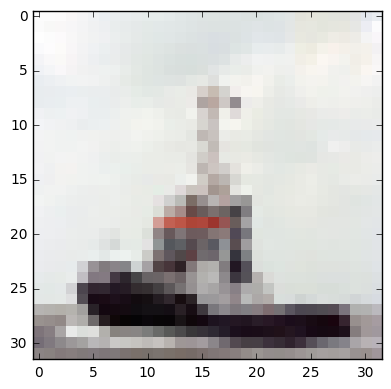

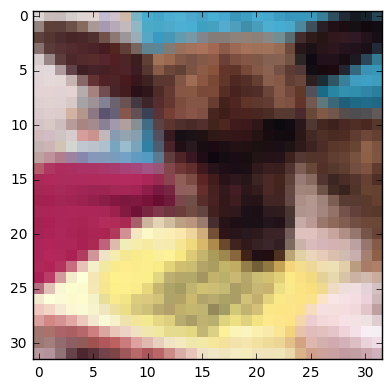

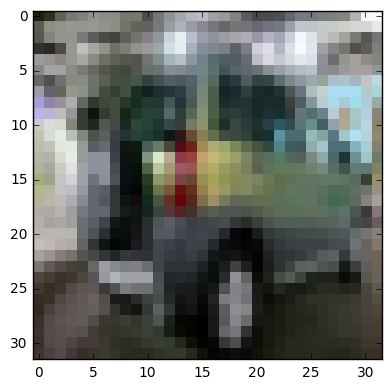

In [65]:
show_image(train_x[0], data_mean, data_std)
show_image(train_x[1], data_mean, data_std)
show_image(train_x[2], data_mean, data_std)